In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext jupyternotify

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>

In [2]:
positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [3]:
dic_dir = "/usr/lib/mecab/dic/mecab-ipadic-neologd"
#dic_dir = "/usr/local/lib/mecab/dic/mecab-ipadic-neologd/"
class Tokenizer:
    def __init__(self, dic_dir):
        mecab = MeCab.Tagger("-Ochasen -d {}".format(dic_dir))
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [29]:
Tokenizer(dic_dir).tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [30]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En", dic_dir=None):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer(dic_dir)
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [31]:
%%notify
level = "word"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja", dic_dir=dic_dir)

# pos:  62402
# neg:  9060
pos/neg: 6.887637969094922


<IPython.core.display.Javascript object>

In [32]:
long_doc = True

In [33]:
len(x_text)

71462

In [34]:
x_text[0]

'書き込む 、 読み出し 、 転送速度 、 いずれ も 満足 です 。 1600 万 画素 の コンパクトカメラ タイプ の デジカメ に 入れる て 撮影 に 使う 、 撮影後 は カード リーダ に 接続 する て 、 撮影 する た 膨大 だ 量 の 画像 データ を サムネイル 表示 に する たり 、 ピックアップ する た 画像 を コピペ する たり する て いる ます が 、 とくに ストレス を 感じる こと ない 、 快適 に 使える て いる ます 。 【 amazon.co.jp 限定 】 の 個体 は 、 SDカード 本体 が シンプル だ 小さい ボール紙 に 挟む れる て いる だけ 。 梱包 は 超 シンプル です が 、 実 売価 格 が 安い 、 性能 に も 満足 出来る て いる ので 買う て 良い た と 思う て いる ます 。 耐久性 は わかる ます ん 。 そこ は 要 経過 観察 です ね 。'

In [35]:
length_list = np.array([len(r)for r in x_text])

In [36]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,430
1,51
2,145
3,178
4,258


In [37]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,71462.000000
mean,197.877165
std,260.944038
min,4.000000
50%,134.000000
75%,228.000000
80%,261.000000
90%,374.000000
95%,535.000000
max,13936.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe373dd40b8>]],
      dtype=object)

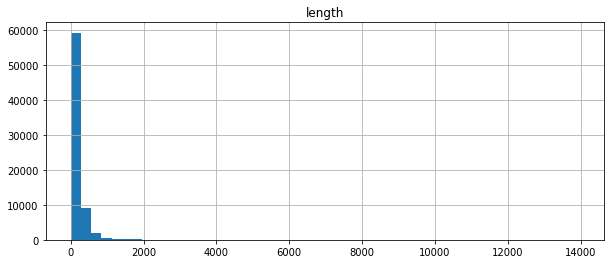

In [38]:
df.hist(bins=50,figsize=(10,4))

In [39]:
max_length = int(df.quantile(0.9)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  374


,length
count,71462.000000
mean,165.509781
std,103.387641
min,4.000000
50%,134.000000
75%,228.000000
80%,261.000000
90%,374.000000
95%,374.000000
max,374.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe373e49518>]],
      dtype=object)

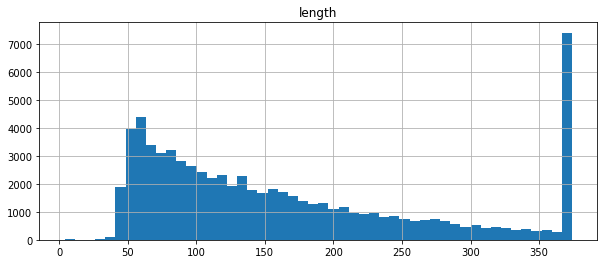

In [40]:
df.hist(bins=50,figsize=(10,4))

In [41]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

In [42]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

<IPython.core.display.Javascript object>

In [43]:
test_percentage = 0.05

In [44]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 53806
Train/Test split: 67889/3573


<IPython.core.display.Javascript object>

In [45]:
print(x_train.shape)

(67889, 374)


In [46]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [47]:
class RNN:
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
                 cell_type, hidden_size, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_text = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_text')
        self.input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        l2_loss = tf.constant(0.0)
        text_length = self._length(self.input_text)

        with tf.device('/cpu:0'), tf.name_scope("text-embedding"):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_text")
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_text)


        with tf.name_scope("rnn"):
            cell = self._get_cell(hidden_size, cell_type)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.dropout_keep_prob)
            all_outputs, _ = tf.nn.dynamic_rnn(cell=cell, inputs=self.embedded_chars, sequence_length=text_length, dtype=tf.float32)
            self.h_outputs = self.last_relevant(all_outputs, text_length)


        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[hidden_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(self.h_outputs, W, b, name="logits")
            self.predictions = tf.argmax(self.logits, 1, name="predictions")


        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

    @staticmethod
    def _get_cell(hidden_size, cell_type):
        if cell_type == "vanilla":
            return tf.nn.rnn_cell.BasicRNNCell(hidden_size)
        elif cell_type == "lstm":
            return tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
        elif cell_type == "gru":
            return tf.nn.rnn_cell.GRUCell(hidden_size)
        else:
            print("ERROR: '" + cell_type + "' is a wrong cell type !!!")
            return None

    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @staticmethod
    def last_relevant(seq, length):
        batch_size = tf.shape(seq)[0]
        max_length = int(seq.get_shape()[1])
        input_size = int(seq.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(seq, [-1, input_size])
        return tf.gather(flat, index)

In [48]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [49]:
cell_type="lstm"#"vanilla"
word2vec=None
embedding_dim=300
hidden_size=128
dropout_keep_prob=0.5
l2_reg_lambda=3.0

In [50]:
batch_size = 64
display_every=10
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs",cell_type+"_"+level, time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/lstm_word/2018_07_21_14_25_11/



In [51]:
with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=allow_soft_placement,
            log_device_placement=log_device_placement)
        
        sess = tf.Session(config=session_conf)
        
        with sess.as_default():
            
            
            rnn = RNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                cell_type=cell_type,
                hidden_size=hidden_size,
                l2_reg_lambda=l2_reg_lambda
            )


            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            grads_and_vars = optimizer.compute_gradients(rnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)


            loss_summary = tf.summary.scalar("loss", rnn.loss)
            acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)

            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_dir = os.path.join(out_dir, "summaries", "test")
            test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

            if save_checkpoint:
                checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
                checkpoint_prefix = os.path.join(checkpoint_dir, "model")
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
            vocab_processor.save(os.path.join(out_dir, "vocab"))


            sess.run(tf.global_variables_initializer())

            # Pre-trained word2vec
            if word2vec:
                # initial matrix with random uniform
                initW = np.random.uniform(-0.25, 0.25, (len(text_vocab_processor.vocabulary_), embedding_dim))
                # load any vectors from the word2vec
                print("Load word2vec file {0}".format(word2vec))
                with open(word2vec, "rb") as f:
                    header = f.readline()
                    vocab_size, layer1_size = map(int, header.split())
                    binary_len = np.dtype('float32').itemsize * layer1_size
                    for line in range(vocab_size):
                        word = []
                        while True:
                            ch = f.read(1).decode('latin-1')
                            if ch == ' ':
                                word = ''.join(word)
                                break
                            if ch != '\n':
                                word.append(ch)
                        idx = text_vocab_processor.vocabulary_.get(word)
                        if idx != 0:
                            initW[idx] = np.fromstring(f.read(binary_len), dtype='float32')
                        else:
                            f.read(binary_len)
                sess.run(rnn.W_text.assign(initW))
                print("Success to load pre-trained word2vec model!\n")


            batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

            for batch in batches:
                x_batch, y_batch = zip(*batch)
                feed_dict = {
                    rnn.input_text: x_batch,
                    rnn.input_y: y_batch,
                    rnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
                train_summary_writer.add_summary(summaries, step)

                if step % display_every == 0:
                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    print("\nEvaluation:")
                    feed_dict_test = {
                        rnn.input_text: x_test,
                        rnn.input_y: y_test,
                        rnn.dropout_keep_prob: 1.0
                    }
                    summaries_test, loss, accuracy = sess.run([test_summary_op, rnn.loss, rnn.accuracy], feed_dict_test)
                    test_summary_writer.add_summary(summaries_test, step)

                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=step)
                    print("Saved model checkpoint to {}\n".format(path))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name text-embedding/W_text:0/grad/hist is illegal; using text-embedding/W_text_0/grad/hist instead.
INFO:tensorflow:Summary name text-embedding/W_text:0/grad/sparsity is illegal; using text-embedding/W_text_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/hist is illegal; using rnn/basic_lstm_cell/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/kernel_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/hist is illegal; using rnn/basic_lstm_cell/bias_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/bias_0/grad/sparsity instead.
INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-07-21T14:28:33.449445: step 440, loss 0.234536, acc 0.96875

Evaluation:
2018-07-21T14:28:33.768918: step 440, loss 0.313428, acc 0.9082

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-440

2018-07-21T14:28:38.276540: step 450, loss 0.254252, acc 0.9375
2018-07-21T14:28:42.536940: step 460, loss 0.415506, acc 0.875

Evaluation:
2018-07-21T14:28:42.853953: step 460, loss 0.310958, acc 0.911559

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-460

2018-07-21T14:28:47.362467: step 470, loss 0.274201, acc 0.921875
2018-07-21T14:28:51.628115: step 480, loss 0.224236, acc 0.953125

Evaluation:
2018-07-21T14:28:51.949126: step 480, loss 0.317318, acc 0.905681

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-480

2018-07-21T14:28:56.408149: step 490, loss 0.300352, acc 0.921875
2018-0

2018-07-21T14:32:16.096105: step 930, loss 0.326621, acc 0.953125
2018-07-21T14:32:20.459044: step 940, loss 0.330798, acc 0.90625

Evaluation:
2018-07-21T14:32:20.783578: step 940, loss 0.277516, acc 0.929471

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-940

2018-07-21T14:32:25.816875: step 950, loss 0.249378, acc 0.9375
2018-07-21T14:32:30.131438: step 960, loss 0.29117, acc 0.90625

Evaluation:
2018-07-21T14:32:30.459262: step 960, loss 0.273448, acc 0.926672

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-960

2018-07-21T14:32:35.211358: step 970, loss 0.233797, acc 0.9375
2018-07-21T14:32:39.766229: step 980, loss 0.319835, acc 0.921875

Evaluation:
2018-07-21T14:32:40.101604: step 980, loss 0.276527, acc 0.929471

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-980

2018-

2018-07-21T14:36:01.694544: step 1420, loss 0.260109, acc 0.935069

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-1420

2018-07-21T14:36:06.187162: step 1430, loss 0.283156, acc 0.921875
2018-07-21T14:36:10.452873: step 1440, loss 0.163238, acc 0.96875

Evaluation:
2018-07-21T14:36:10.779835: step 1440, loss 0.256488, acc 0.936188

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-1440

2018-07-21T14:36:15.343362: step 1450, loss 0.297201, acc 0.921875
2018-07-21T14:36:19.568732: step 1460, loss 0.269776, acc 0.9375

Evaluation:
2018-07-21T14:36:19.896296: step 1460, loss 0.267613, acc 0.926952

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-1460

2018-07-21T14:36:24.388988: step 1470, loss 0.196405, acc 0.96875
2018-07-21T14:36:28.658511: step 1480, loss 0.216664, acc 0.96875

Eva

2018-07-21T14:39:43.462973: step 1910, loss 0.296231, acc 0.9375
2018-07-21T14:39:47.710009: step 1920, loss 0.280329, acc 0.890625

Evaluation:
2018-07-21T14:39:48.034693: step 1920, loss 0.254771, acc 0.933949

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-1920

2018-07-21T14:39:52.542938: step 1930, loss 0.267048, acc 0.9375
2018-07-21T14:39:56.819874: step 1940, loss 0.244791, acc 0.9375

Evaluation:
2018-07-21T14:39:57.148801: step 1940, loss 0.251159, acc 0.933949

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-1940

2018-07-21T14:40:01.634449: step 1950, loss 0.289086, acc 0.921875
2018-07-21T14:40:05.858349: step 1960, loss 0.175459, acc 0.96875

Evaluation:
2018-07-21T14:40:06.185558: step 1960, loss 0.242492, acc 0.937028

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2400

2018-07-21T14:43:29.841852: step 2410, loss 0.222211, acc 0.96875
2018-07-21T14:43:34.125861: step 2420, loss 0.264588, acc 0.953125

Evaluation:
2018-07-21T14:43:34.444758: step 2420, loss 0.239909, acc 0.940946

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2420

2018-07-21T14:43:38.949061: step 2430, loss 0.217783, acc 0.96875
2018-07-21T14:43:43.189996: step 2440, loss 0.212473, acc 0.9375

Evaluation:
2018-07-21T14:43:43.509377: step 2440, loss 0.249238, acc 0.935628

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2440

2018-07-21T14:43:48.016135: step 2450, loss 0.189676, acc 1
2018-07-21T14:43:52.257005: step 2460, loss 0.207032, acc 0.953125

Evaluation:
2018-07-21T14:43:52.582918: step 2460, loss 0.245801, acc 0.94262

2018-07-21T14:47:11.390443: step 2900, loss 0.148729, acc 1

Evaluation:
2018-07-21T14:47:11.707499: step 2900, loss 0.234017, acc 0.945144

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2900

2018-07-21T14:47:16.176110: step 2910, loss 0.208479, acc 0.953125
2018-07-21T14:47:20.407691: step 2920, loss 0.132825, acc 1

Evaluation:
2018-07-21T14:47:20.721804: step 2920, loss 0.241404, acc 0.944584

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2920

2018-07-21T14:47:25.243960: step 2930, loss 0.218696, acc 0.953125
2018-07-21T14:47:29.482270: step 2940, loss 0.194694, acc 0.96875

Evaluation:
2018-07-21T14:47:29.804307: step 2940, loss 0.233802, acc 0.943465

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-2940

2018-07-21T14:47:34.306575: step 2950, loss 0.227269, acc 0.953125
2

2018-07-21T14:50:53.298549: step 3390, loss 0.127661, acc 1
2018-07-21T14:50:57.631971: step 3400, loss 0.122889, acc 1

Evaluation:
2018-07-21T14:50:57.953326: step 3400, loss 0.234757, acc 0.948223

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3400

2018-07-21T14:51:02.460479: step 3410, loss 0.173821, acc 0.96875
2018-07-21T14:51:06.713241: step 3420, loss 0.168222, acc 0.984375

Evaluation:
2018-07-21T14:51:07.032508: step 3420, loss 0.236687, acc 0.940666

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3420

2018-07-21T14:51:11.553158: step 3430, loss 0.211622, acc 0.953125
2018-07-21T14:51:15.753657: step 3440, loss 0.132964, acc 1

Evaluation:
2018-07-21T14:51:16.072643: step 3440, loss 0.234536, acc 0.942905

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3440

2018-07-

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3880

2018-07-21T14:54:41.680447: step 3890, loss 0.136224, acc 0.984375
2018-07-21T14:54:45.942905: step 3900, loss 0.141678, acc 0.984375

Evaluation:
2018-07-21T14:54:46.262082: step 3900, loss 0.233382, acc 0.941226

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3900

2018-07-21T14:54:50.770340: step 3910, loss 0.175227, acc 0.984375
2018-07-21T14:54:55.022464: step 3920, loss 0.202943, acc 0.953125

Evaluation:
2018-07-21T14:54:55.345330: step 3920, loss 0.236781, acc 0.942345

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-3920

2018-07-21T14:54:59.837649: step 3930, loss 0.148528, acc 0.984375
2018-07-21T14:55:04.074040: step 3940, loss 0.134396, acc 1

Evaluation:
2018-07-21T14:55:04.395729: step 3940, loss 0.233716, acc 0.9

2018-07-21T14:58:23.005204: step 4380, loss 0.124343, acc 1

Evaluation:
2018-07-21T14:58:23.326404: step 4380, loss 0.232264, acc 0.946544

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4380

2018-07-21T14:58:27.817575: step 4390, loss 0.120264, acc 1
2018-07-21T14:58:32.133438: step 4400, loss 0.168726, acc 0.96875

Evaluation:
2018-07-21T14:58:32.457351: step 4400, loss 0.24872, acc 0.937587

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4400

2018-07-21T14:58:36.950821: step 4410, loss 0.17881, acc 0.96875
2018-07-21T14:58:41.188180: step 4420, loss 0.191759, acc 0.96875

Evaluation:
2018-07-21T14:58:41.506687: step 4420, loss 0.241497, acc 0.944864

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4420

2018-07-21T14:58:45.998188: step 4430, loss 0.109252, acc 1
2018-07-21T1

2018-07-21T15:02:04.962680: step 4870, loss 0.132739, acc 1
2018-07-21T15:02:09.287677: step 4880, loss 0.18862, acc 0.96875

Evaluation:
2018-07-21T15:02:09.610898: step 4880, loss 0.236897, acc 0.946264

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4880

2018-07-21T15:02:14.082234: step 4890, loss 0.280807, acc 0.921875
2018-07-21T15:02:18.302223: step 4900, loss 0.122336, acc 1

Evaluation:
2018-07-21T15:02:18.624175: step 4900, loss 0.233353, acc 0.947383

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4900

2018-07-21T15:02:23.130799: step 4910, loss 0.152979, acc 0.984375
2018-07-21T15:02:27.396063: step 4920, loss 0.129046, acc 1

Evaluation:
2018-07-21T15:02:27.722022: step 4920, loss 0.232606, acc 0.945144

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-4920

2018-07-2

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5360

2018-07-21T15:05:51.288160: step 5370, loss 0.120429, acc 1
2018-07-21T15:05:55.553495: step 5380, loss 0.127823, acc 1

Evaluation:
2018-07-21T15:05:55.875666: step 5380, loss 0.238237, acc 0.942065

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5380

2018-07-21T15:06:00.358851: step 5390, loss 0.169092, acc 0.984375
2018-07-21T15:06:04.557381: step 5400, loss 0.185147, acc 0.96875

Evaluation:
2018-07-21T15:06:04.884366: step 5400, loss 0.238112, acc 0.944305

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5400

2018-07-21T15:06:09.351396: step 5410, loss 0.118832, acc 1
2018-07-21T15:06:13.568138: step 5420, loss 0.11669, acc 1

Evaluation:
2018-07-21T15:06:13.888352: step 5420, loss 0.238439, acc 0.945704

Saved model chec

2018-07-21T15:09:35.666439: step 5860, loss 0.237079, acc 0.942065

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5860

2018-07-21T15:09:40.197687: step 5870, loss 0.151122, acc 0.984375
2018-07-21T15:09:44.499135: step 5880, loss 0.179377, acc 0.96875

Evaluation:
2018-07-21T15:09:44.813670: step 5880, loss 0.233406, acc 0.943185

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5880

2018-07-21T15:09:49.334630: step 5890, loss 0.168363, acc 0.984375
2018-07-21T15:09:53.585923: step 5900, loss 0.136931, acc 0.984375

Evaluation:
2018-07-21T15:09:53.910463: step 5900, loss 0.243599, acc 0.942625

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-5900

2018-07-21T15:09:58.386448: step 5910, loss 0.128398, acc 1
2018-07-21T15:10:02.601803: step 5920, loss 0.139008, acc 0.984375

Evalua

2018-07-21T15:13:24.812800: step 6360, loss 0.132016, acc 1

Evaluation:
2018-07-21T15:13:25.139008: step 6360, loss 0.236127, acc 0.944025

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-6360

2018-07-21T15:13:29.943023: step 6370, loss 0.134414, acc 0.984375
2018-07-21T15:13:34.645718: step 6380, loss 0.124435, acc 1

Evaluation:
2018-07-21T15:13:34.976410: step 6380, loss 0.238661, acc 0.943465

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-6380

2018-07-21T15:13:39.848150: step 6390, loss 0.15372, acc 0.984375
2018-07-21T15:13:44.064470: step 6400, loss 0.114168, acc 1

Evaluation:
2018-07-21T15:13:44.386933: step 6400, loss 0.242981, acc 0.944025

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_word/2018_07_21_14_25_11/checkpoints/model-6400

2018-07-21T15:13:48.901850: step 6410, loss 0.116067, acc 1
2018-07-21T15:1

KeyboardInterrupt: 